# Bibliotecas

In [1]:
import os

try:
    import wget
except:
    !pip install wget
    import wget

import matplotlib.pyplot as plt
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import cv2 as cv

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=0720d0ac8aa038f33e9a606e2796bc20979dc26e349f097a3d51dae0269185c2
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
#This function creates a figure to show subplots automatically
def show_subplot(images, titles, gridFormat, figSize=(6, 6), cmap="gray", output_fig_name="output.png", export=False):
    fig = plt.figure(figsize=figSize, dpi=150)
    st = fig.suptitle(output_fig_name, fontsize="large")

    for idx, image in enumerate(images):
        idx_curr_img = int(str(gridFormat[0]) + str(gridFormat[1]) + str(idx+1))
        plt.subplot(idx_curr_img).set_title(titles[idx])
        plt.subplot(idx_curr_img).axis('off')
        plt.imshow(image, cmap=cmap)

    fig.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.85)

    if export:
        plt.savefig(output_fig_name, dpi=300)

    plt.show()

In [3]:
#This function load images using IMAGEIO library
def load_image_imageio(path_img, resize=None):
    img = imageio.imread(path_img)

    if resize:
        resCols, resRows = resize
        img = Image.fromarray(img).resize((resCols, resRows))

    return np.array(img)

In [4]:
#This function load and converts '.pfm' files into images
def load_pfm_files(path_file, resize=None, normalize=None):
    #Reference: https://copyprogramming.com/howto/opencv-how-to-read-pfm-files

    #Load input data
    pfm_img = cv.imread(path_file, cv.IMREAD_UNCHANGED)

    # Remove infinite value to display
    pfm_img[pfm_img==np.inf] = 0

    if resize:
        resCols, resRows = resize
        pfm_img = cv.resize(pfm_img,
                           (resCols, resRows),
                            interpolation = cv.INTER_LINEAR) #Image.fromarray(pfm_img).resize((resCols, resRows))

    # Normalize
    if normalize:
        min, max = 0, 255
        pfm_img = cv.normalize(pfm_img, None, min, max, cv.NORM_MINMAX).astype(np.float32)

    return pfm_img

# GET AND PROCESS INPUT DATA

In [5]:
#Set parameters
new_size = (512,512)    # Images resolution
features_technique = 3  # 1) Grayscale, 2) RGB, 3) Raft Stereo, 4) Mobile Net

path_imgL = "im0.png"
path_imgR = "im1.png"

path_gt_L = "disp0.pfm"
path_gt_R = "disp1.pfm"

In [6]:
# DATASET: https://vision.middlebury.edu/stereo/data/scenes2014/datasets/
url = 'https://vision.middlebury.edu/stereo/data/scenes2014/datasets/Flowers-perfect/'
if not os.path.isfile(path_imgL):
    wget.download(url+path_imgL)
if not os.path.isfile(path_imgR):
    wget.download(url+path_imgR)
if not os.path.isfile(path_gt_L):
    wget.download(url+path_gt_L)
if not os.path.isfile(path_gt_R):
    wget.download(url+path_gt_R)

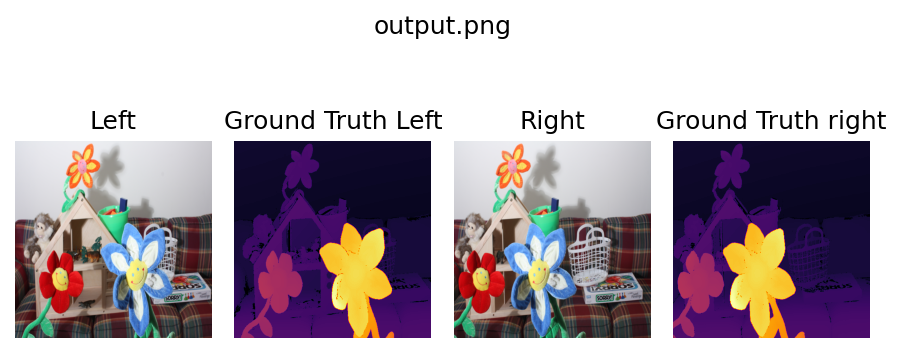

In [7]:
#Load Images
imgL = load_image_imageio(path_imgL, resize=new_size)
imgR = load_image_imageio(path_imgR, resize=new_size)

#Load Ground Truth
gt_L = load_pfm_files(path_gt_L, resize=new_size)
gt_R = load_pfm_files(path_gt_R, resize=new_size)

#Show images side-by-side
show_subplot(images=[imgL, gt_L, imgR, gt_R],
             titles=["Left", "Ground Truth Left", "Right", "Ground Truth right"],
             gridFormat=(1, 4),
             figSize=(6, 3),
             cmap="inferno")

# Edge Detection

Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html

In [8]:
from scipy import ndimage, datasets

def get_sobel(img):
    sobel_h = ndimage.sobel(img, 0)  # horizontal gradient
    sobel_v = ndimage.sobel(img, 1)  # vertical gradient
    magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
    magnitude = magnitude / np.max(magnitude)  # normalization [0, 1]
    alphas = 1 - magnitude # Using to data quality estimation
    return alphas

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [12]:
edges_L = get_sobel(rgb2gray(imgL))

In [13]:
edges_R = get_sobel(rgb2gray(imgR))

In [ ]:
# # Exporting Figures
# plt.imshow(edges_L, cmap="gray")
# plt.savefig("edges_R.png", dpi=300)

In [14]:
# After Normalization
np.min(edges_L), np.max(edges_L), np.min(edges_R), np.max(edges_R)

(0.0, 1.0, 0.0, 1.0)

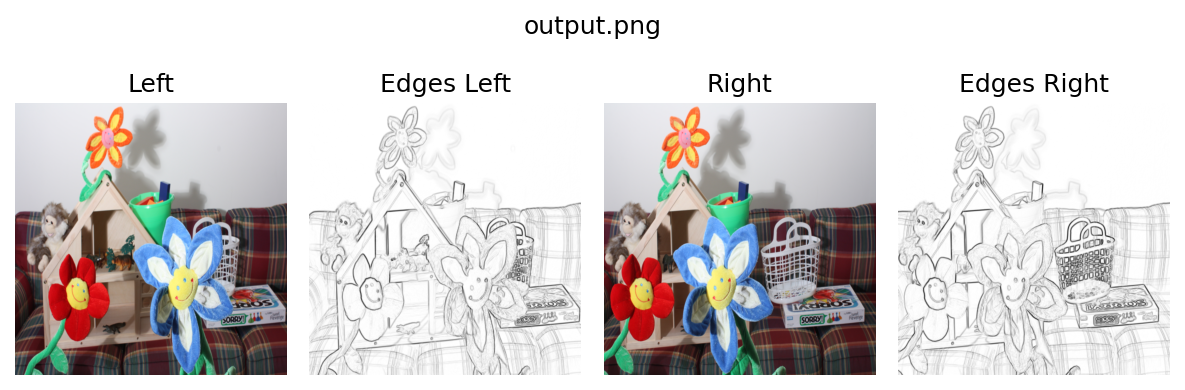

In [15]:
#Show images side-by-side
show_subplot(images=[imgL, edges_L, imgR, edges_R],
             titles=["Left", "Edges Left", "Right", "Edges Right"],
             gridFormat=(1, 4),
             figSize=(8, 3),
             cmap="gray")

In [16]:
import plotly.express as px

fig = px.imshow(edges_L, color_continuous_scale='gray')
fig.show()

Output hidden; open in https://colab.research.google.com to view.